<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/err/FII_percentile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [16]:
nifty=pd.read_csv('nifty50_data.csv')
nif=nifty.reset_index()
nif.columns=['index','Date','Open','High','Low','Close','Volume']
nif['Date']=pd.to_datetime(nif['Date'],format='%Y-%m-%d').dt.tz_localize(None)

In [17]:
content_path='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'
def read_data_file(file_name, content_path):
    return pd.read_csv(content_path + file_name, sep='/t' , header=None)

def read_and_combine_data_files(file_names, content_path):
    combined_data = []

    for file_name in file_names:
        data = read_data_file(file_name, content_path)
        combined_data.extend(data[0].tolist())

    return combined_data

def create_dataframe_from_list(data, group_size):
    df = pd.DataFrame(columns=range(group_size)) # Create an empty DataFrame with columns
    for i in range(0, len(data), group_size):
        df.loc[len(df)] = data[i:i + group_size] # Add rows using loc
    return df


file_names = [f'fii{i}.txt' for i in range(1, 9)]
group_size = 7

data = read_and_combine_data_files(file_names, content_path)
df = create_dataframe_from_list(data, group_size)
df.to_csv('fii.csv')

fii_fig = pd.read_csv('/content/fii.csv')
fii = fii_fig.copy()

fii_fig = fii_fig[::-1]
fii_fig.columns = ['Index', 'Date', 'FIIcall', 'FIIput', 'FIIFuture', 'FIIFutOI', 'FIICash', 'DIIcash']
fii_fig.drop('Index',inplace=True,axis=1)
fii_fig['Date']=pd.to_datetime(fii_fig['Date'],format='%d %b %Y')
#nif['Date']=pd.to_datetime(nif['Date'],format='%Y-%m-%d').dt.tz_localize(None)
#fii_fig=fii_fig.set_index('Date')

In [18]:

# Calculate 10-day moving average of FIICash
fii_fig['FIICash_MA10'] = fii_fig['FIICash'].rolling(window=20, min_periods=1).mean()

# Function to calculate rolling percentile
def rolling_percentile(series, window):
    return series.rolling(window=window, min_periods=1).apply(lambda x: np.percentile(x, (x.rank(pct=True) * 100).iloc[-1]))

# Calculate rolling percentile (0-100) for the 10-day moving average
fii_fig['FIICash_MA10_Percentile'] = fii_fig['FIICash_MA10'].rolling(window=50, min_periods=1).apply(lambda x: (x.rank(pct=True).iloc[-1]) * 100)
# Function to calculate rolling z-score
def rolling_zscore(series, window):
    return (series - series.rolling(window=window, min_periods=1).mean()) / series.rolling(window=window, min_periods=1).std()

# Calculate rolling z-score for the 10-day moving average
fii_fig['FIICash_MA10_ZScore'] = rolling_zscore(fii_fig['FIICash_MA10'], window=20)


In [19]:
fii_fig=fii_fig.set_index('Date')
nif.set_index('Date',inplace=True)
# download nifty price and concat with fii data
fii_fig=fii_fig.join(nif)

In [20]:
fii_fig=fii_fig.tail(1500)

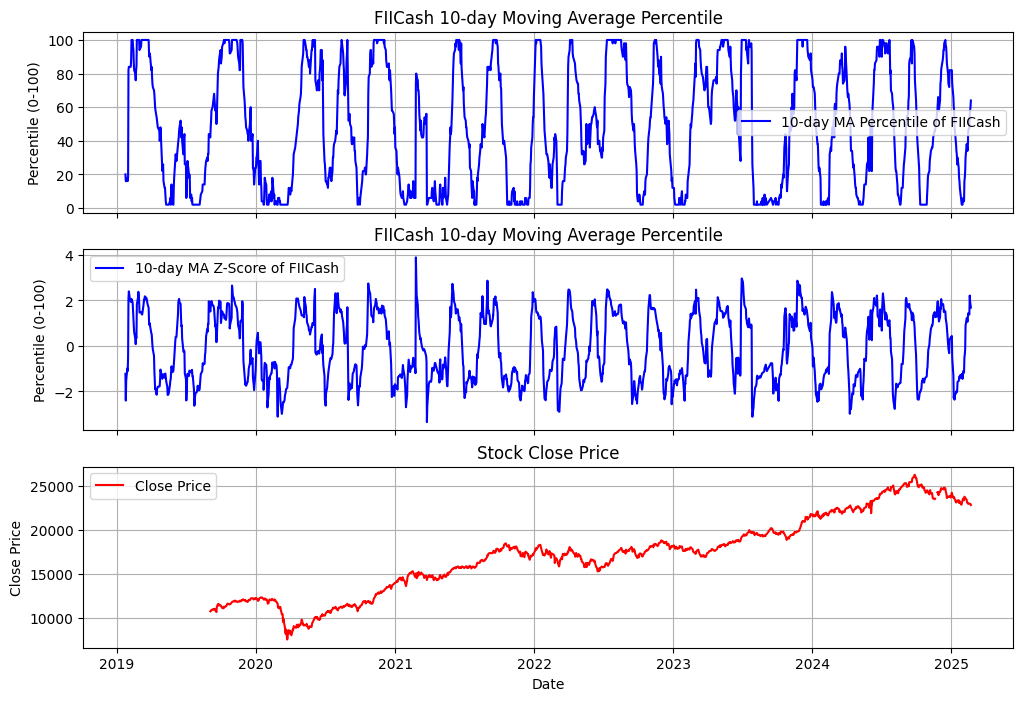

In [22]:
# Create subplots
fig, ax1 = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Plot FIICash_MA10_Percentile
ax1[0].plot(fii_fig['FIICash_MA10_Percentile'], label='10-day MA Percentile of FIICash', color='blue')
ax1[0].set_ylabel('Percentile (0-100)')
ax1[0].set_title('FIICash 10-day Moving Average Percentile')
ax1[0].legend()
ax1[0].grid()

# Plot FIICash_MA10_Percentile
ax1[1].plot(fii_fig['FIICash_MA10_ZScore'], label='10-day MA Z-Score of FIICash', color='blue')
ax1[1].set_ylabel('Percentile (0-100)')
ax1[1].set_title('FIICash 10-day Moving Average Percentile')
ax1[1].legend()
ax1[1].grid()

# Plot Close price
ax1[2].plot( fii_fig['Close'], label='Close Price', color='red')
ax1[2].set_xlabel('Date')
ax1[2].set_ylabel('Close Price')
ax1[2].set_title('Stock Close Price')
ax1[2].legend()
ax1[2].grid()

plt.show()